<a href="https://colab.research.google.com/github/POLimmuno/PaulLeclerc_225a/blob/main/bms225a_ds_workshop_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
# install scanpy with additional dependences
# leiden for clustering, harmony for batch correction and skmisc which is needed for HVG selection
!pip install --quiet 'scanpy[leiden,harmony,skmisc]'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.9 MB/s eta 0:00:00


The following cell downloads the original data and creates the data files `/content/blood_RNA_raw_counts.h5ad` and `/content/blood_RNA_raw_counts_SCG12.h5ad` that we will use for our analysis.

In [2]:
# @title Download Data and create the **raw data** files that we will use for our analysis
################# THIS IS NOT PART OF THE WORKFLOW ##################
import os

if not os.path.exists('/content/blood_RNA.h5ad'):
  # downloading the data from the paper takes ~1min
  !wget https://figshare.com/ndownloader/files/38849385?private_link=8aaa376913da23ae0def -O blood_RNA.h5ad > /dev/null 2>&1


if not os.path.exists('/content/blood_RNA_raw_counts.h5ad'):
  # -- create the raw data by removing all processed data information from the author's file
  import scanpy as sc
  # load the single cell RNA seq dataset from the h5ad file
  adata_processed = sc.read_h5ad('blood_RNA.h5ad') # AnnData object
  X_raw_counts = adata_processed.layers['counts']
  # the var dataframe
  raw_var_df = adata_processed.raw.var.copy()
  for i in raw_var_df.columns:
    del raw_var_df[i]
  raw_var_df['gene_name'] = raw_var_df.index
  # the obs dataframe
  raw_obs_df = adata_processed.obs[['LIBRARY',	'CoLabs_patient',	'condition']]
  raw_obs_df.columns = ['LIBRARY_ID', 'patient_id', 'condition']
  # create the anndata object
  adata = sc.AnnData(X = X_raw_counts, var=raw_var_df, obs=raw_obs_df)
  adata.write_h5ad('blood_RNA_raw_counts.h5ad')
  adata=adata[ adata.obs['LIBRARY_ID'] == 'XAUT1-POOL-SCG12']
  adata.write_h5ad('blood_RNA_raw_counts_SCG12.h5ad')
  del adata, adata_processed # delete the all data

# Single cell RNA seq analysis (single batch)
## Let's do a single batch first
The `'blood_RNA_raw_counts_SCG12.h5ad'` file only contains the single-cell data from a single sequencing batch (library):

LIBRARY_ID: `XAUT1-POOL-SCG12`.

In [3]:
import pandas as pd
import scanpy as sc

In [ ]:
### Settings ###

# (optional) Show more columns in output
pd.set_option('display.max_columns', 50)

# (optional) Set parameters for the figures // sc.settings.set_figure_params?
sc.settings.set_figure_params(dpi=80,fontsize=16, facecolor="white",figsize=(8,6),color_map='viridis')

# (optional) Suppress all warnings -- not recommended when working on your research projects!
import warnings
warnings.filterwarnings("ignore")

# print out the package versions
print('scanpy version:', sc.__version__)

## STEP 0: Load the data (raw counts)

In [4]:
###################################################### <- this will mark the functions that will change/update adata
adata = sc.read_h5ad('blood_RNA_raw_counts_SCG12.h5ad') # load the AnnData object from the h5ad file

In [15]:
adata

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition'
    var: 'gene_name'

In [ ]:
# [🔺] lets explore what is in adata
# adata.obs, adata.X, adata.var, adata.var_names

In [17]:
adata.var

,gene_name
RP11-34P13.7,RP11-34P13.7
RP11-34P13.15,RP11-34P13.15
RP11-34P13.16,RP11-34P13.16
RP11-34P13.13,RP11-34P13.13
FO538757.2,FO538757.2
...,...
RSPH1,RSPH1
IMMTP1,IMMTP1
LINC00315,LINC00315
AL133493.2,AL133493.2


## STEP 1: Quality control

In [18]:
######################################################
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [19]:
adata.var.head()

,gene_name,mt
RP11-34P13.7,RP11-34P13.7,False
RP11-34P13.15,RP11-34P13.15,False
RP11-34P13.16,RP11-34P13.16,False
RP11-34P13.13,RP11-34P13.13,False
FO538757.2,FO538757.2,False


In [20]:
# [🔺] pandas practice: select the var rows that correspond to mitochondrial genes
# Hint: slice adata.var where the 'mt' column of adata.var is equal to True
adata.var[ adata.var['mt'] == True]

,gene_name,mt
MT-RNR1,MT-RNR1,True
MT-TV,MT-TV,True
MT-RNR2,MT-RNR2,True
MT-TL1,MT-TL1,True
MT-ND1,MT-ND1,True
MT-TM,MT-TM,True
MT-ND2,MT-ND2,True
MT-TA,MT-TA,True
MT-TC,MT-TC,True
MT-CO1,MT-CO1,True


In [21]:
# [🔹] for practice you can also add a column that indicates whether a gene is ribosomal
# ribosomal genes start with "RP" for human, "Rp" for mouse
adata.var["rp"] = adata.var_names.str.startswith("RP")

In [24]:
adata.var[ adata.var['rp'] == True]

,gene_name,mt,rp
RP11-34P13.7,RP11-34P13.7,False,True
RP11-34P13.15,RP11-34P13.15,False,True
RP11-34P13.16,RP11-34P13.16,False,True
RP11-34P13.13,RP11-34P13.13,False,True
RP4-669L17.10,RP4-669L17.10,False,True
...,...,...,...
RP11-218C14.5,RP11-218C14.5,False,True
RPL21P129,RPL21P129,False,True
RP1-149A16.17,RP1-149A16.17,False,True
RP5-1119A7.11,RP5-1119A7.11,False,True


### Calculate QC metrics

In [25]:
adata # lets remind ourseleves about adata, the following command will add a lot of information

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition'
    var: 'gene_name', 'mt', 'rp'

In [26]:
######################################################
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)

In [27]:
adata

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Filter genes

In [28]:
######################################################
sc.pp.filter_genes(adata,min_cells=5) #filter genes that are expressed in fewer than 5 cells

In [29]:
adata # notice that the number of genes decreased

AnnData object with n_obs × n_vars = 6410 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Visualize QC metrics (cells)

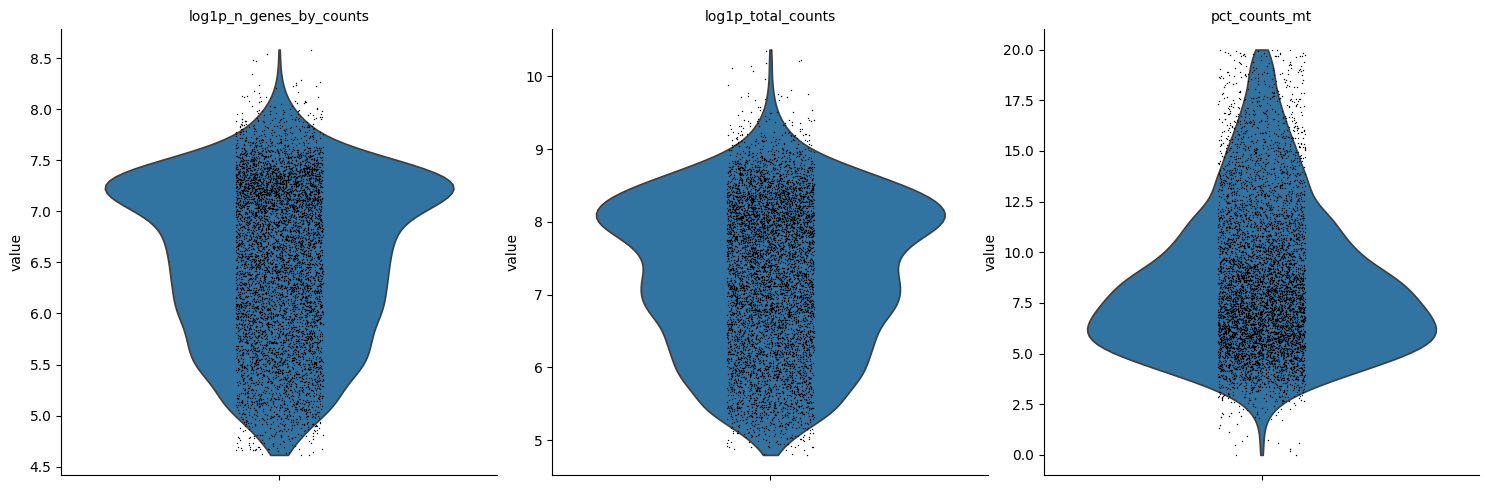

In [30]:
sc.pl.violin(
    adata,
    keys = ["log1p_n_genes_by_counts", "log1p_total_counts", "pct_counts_mt"],
    jitter=0.1,
    multi_panel=True,
    size=1
)

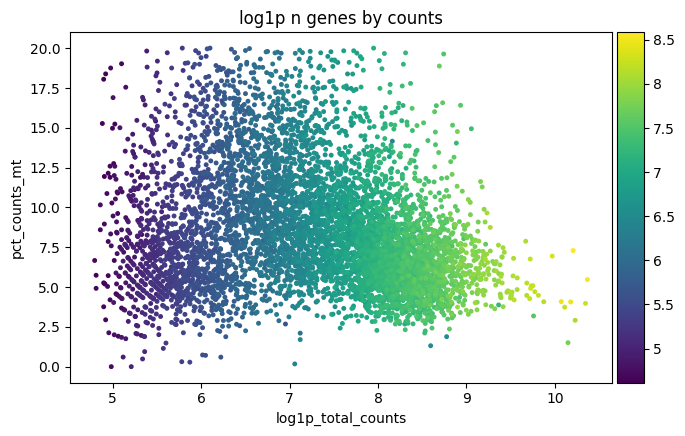

In [31]:
sc.pl.scatter(adata, "log1p_total_counts", "pct_counts_mt", color="log1p_n_genes_by_counts",size=50)

### Filter cells

In [38]:
# [🔺] pandas practice: How many cells have log1p_total_counts above 8?

condition = adata.obs['log1p_total_counts']> 8
condition.sum()

1946

In [39]:
##################################################
# filter out cells by choosing QC thresholds
# e.g., based on the above plots, ok to be lenient we can revisit this after clustering
#%mt good quality mouse data should be around 5, good quality human should be around 10

adata = adata[ adata.obs['log1p_total_counts']> 6.5 ]
adata = adata[ adata.obs['pct_counts_mt']< 12.5 ]

In [40]:
adata # notice that the number of cells decreased

View of AnnData object with n_obs × n_vars = 4104 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Doublet detection (scrublet)

- We expect very few doublets in this particular case. The majority of doublets were removed using genetic information / patient SNPs.


In [41]:
#############################################
# doublet detection with scrublet
sc.pp.scrublet(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scrublet/__init__.py:289: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


In [42]:
adata # notice the columns 'doublet_score' and 'predicted_doublet' were added in obs. Also .uns appeared.

AnnData object with n_obs × n_vars = 4104 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

In [43]:
# .value_counts(): count how many times a value appears in a column of a dataframe
adata.obs.value_counts('predicted_doublet')

,count
predicted_doublet,
False,4103
True,1


In [47]:
##############################################
# [🔺] AnnData challenge: filter out detected doublets!
# Hint1: adata can be sliced as a DataFrame, i.e., adata[ some condition here ]
# Hint2: adata.obs has the predicted_doublet column which is False for the cells we want to keep

adata = adata[adata.obs['predicted_doublet'] == False]





In [50]:
adata

View of AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

## STEP 2: Normalization and log-transformation

In [51]:
##############################################
# Before normalization, we want to save the count data to a new layer
adata.layers["counts"] = adata.X.copy()

<ipython-input-51-ac8e4e17c34e>:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [52]:
adata

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'
    layers: 'counts'

In [53]:
##############################################
# Normalizing to 10K total counts
# this normalization process is confusing, figure this out
sc.pp.normalize_total(adata,target_sum=10000) # CP10k normalization

- `target_sum = 10000` is kind of arbitrary but very widely used. If we don't specify the target_sum parameter, `sc.pp.normalize_total(adata)` by default will normalize to the median of the total counts.


In [54]:
# The only thing that changed is the X matrix (gene expression),
# which is now normalized to sum to 10K
adata.X.sum(1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

In [55]:
##############################################
# Logarithmize the data
sc.pp.log1p(adata)

In [56]:
adata.X.sum(1) # the X matrix changed. Each entry is now log(1+x)

matrix([[2206.50442962],
        [1608.12643059],
        [2252.01947841],
        ...,
        [2139.56974705],
        [1353.63176362],
        [1412.3376114 ]])

In [57]:
######################################################
# [🔺] save the log1p normalized counts to a new layer! Let's call it 'log1p'
# We want to keep these around (useful for plotting and differential expression analysis)

adata.layers["log1p"] = adata.X.copy()





In [58]:
adata

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'log1p'
    layers: 'counts', 'log1p'

## STEP 3: Highly variable genes (feature selection)

In [59]:
######################################################
sc.pp.highly_variable_genes(adata, n_top_genes = 2000,
                            flavor='seurat_v3',
                            layer='counts')

In [60]:
# This added information in the var dataframe
adata.var

,gene_name,mt,rp,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
RP11-34P13.15,RP11-34P13.15,False,True,44,0.006864,0.006841,99.313573,44.0,3.806662,44,False,NaN,0.009262,0.009178,0.868907
RP11-34P13.13,RP11-34P13.13,False,True,46,0.007332,0.007306,99.282371,47.0,3.871201,46,False,NaN,0.009262,0.009666,0.915067
FO538757.1,FO538757.1,False,False,103,0.016381,0.016248,98.393136,105.0,4.663439,103,False,NaN,0.022423,0.022413,0.870039
AP006222.2,AP006222.2,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001219,0.001217,0.979876
RP4-669L17.10,RP4-669L17.10,False,True,9,0.001404,0.001403,99.859594,9.0,2.302585,9,False,NaN,0.001950,0.001946,0.950158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AP001432.14,AP001432.14,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001219,0.001217,0.979876
UMODL1-AS1,UMODL1-AS1,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001219,0.001217,0.979876
AP001469.7,AP001469.7,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.000975,0.000974,0.991094
MT-TY,MT-TY,True,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001219,0.001217,0.979876


In [61]:
# .sort_values(): sort a dataframe with respect to the values of a given column
# .head(10) prints the top 10
adata.var.sort_values('highly_variable_rank').head(10)

,gene_name,mt,rp,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
IGKV3-15,IGKV3-15,False,False,53,0.209984,0.190607,99.173167,1346.0,7.205635,53,True,0.0,0.311723,24.994711,16.025208
TRBV7-2,TRBV7-2,False,False,121,0.172855,0.159441,98.112324,1108.0,7.011214,121,True,1.0,0.259810,5.290844,13.807572
PTGDS,PTGDS,False,False,257,0.294072,0.257794,95.990640,1885.0,7.542213,257,True,2.0,0.405313,13.505842,13.573484
FCER1A,FCER1A,False,False,118,0.122933,0.115944,98.159126,788.0,6.670766,118,True,3.0,0.182793,3.648197,13.070773
IGKV4-1,IGKV4-1,False,False,182,2.540562,1.264285,97.160686,16285.0,9.698061,182,True,4.0,2.733122,3185.041631,12.904304
LYPD2,LYPD2,False,False,173,0.147894,0.137929,97.301092,948.0,6.855409,173,True,5.0,0.195710,3.189138,11.857559
IGLV1-44,IGLV1-44,False,False,60,0.074259,0.071631,99.063963,476.0,6.167516,60,True,6.0,0.107970,4.020763,11.017962
JCHAIN,JCHAIN,False,False,234,0.612793,0.477967,96.349454,3928.0,8.276140,234,True,7.0,0.839386,315.131925,10.945086
IGKC,IGKC,False,False,558,1.987207,1.094339,91.294852,12738.0,9.452423,558,True,8.0,2.973190,3600.363006,10.672587
HBA2,HBA2,False,False,586,0.370515,0.315186,90.858034,2375.0,7.773174,586,True,9.0,0.460151,13.732627,10.301628


## STEP 4: Dimensionality reduction with PCA

In [62]:
adata # lets remind ourseleves about adata, the PCA will add a more information

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts', 'log1p'

In [63]:
#####################################################################
# Before PCA we typically scale features to unit variance (common step but not absolutely necessary)
# Note that this changes adata.X
sc.pp.scale(adata, zero_center=False) # we don't want to zero center.

In [64]:
#####################################################################
# PCA: by default this function uses only the highly variable genes
sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

In [65]:
# notice that the .obsm appeared that holds representations of the cells (embeddings)
adata

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p'

In [66]:
# X_pca is a matrix of reduced dimensions (n_comps=50 in our case).
adata.obsm['X_pca'].shape

(4103, 50)

### Visualize PCA

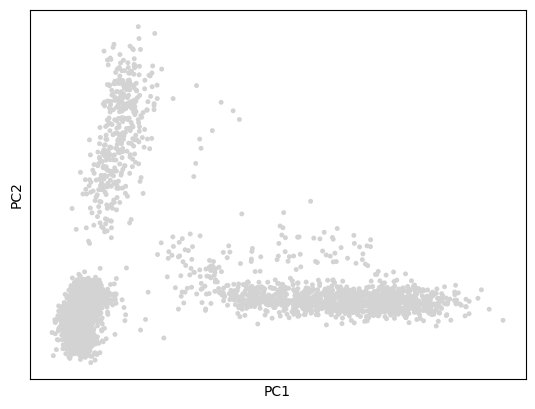

In [67]:
sc.pl.pca(adata,size=50)

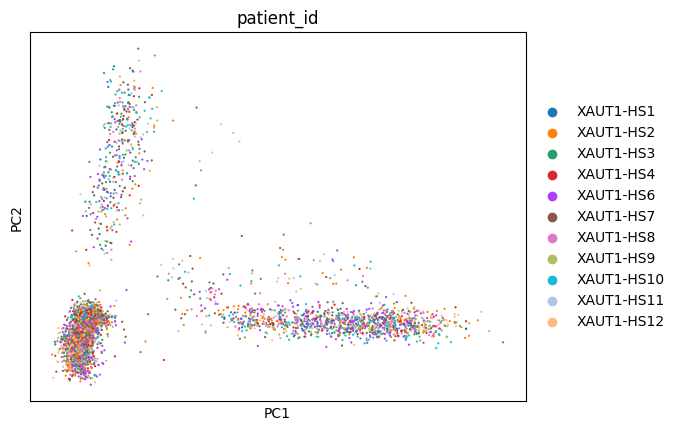

In [68]:
sc.pl.pca(adata,color='patient_id',size=10)

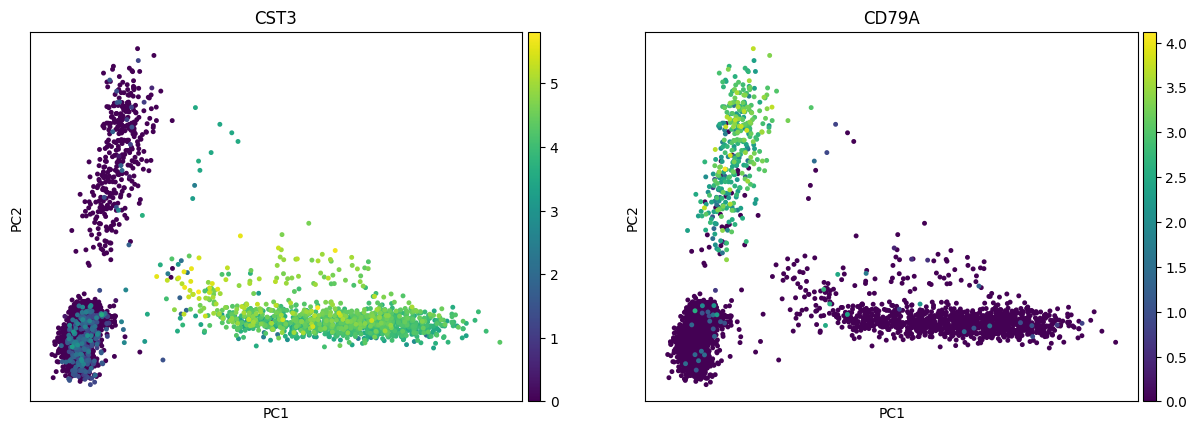

In [69]:
sc.pl.pca(adata,color=['CST3','CD79A'],size=50,layer='log1p')

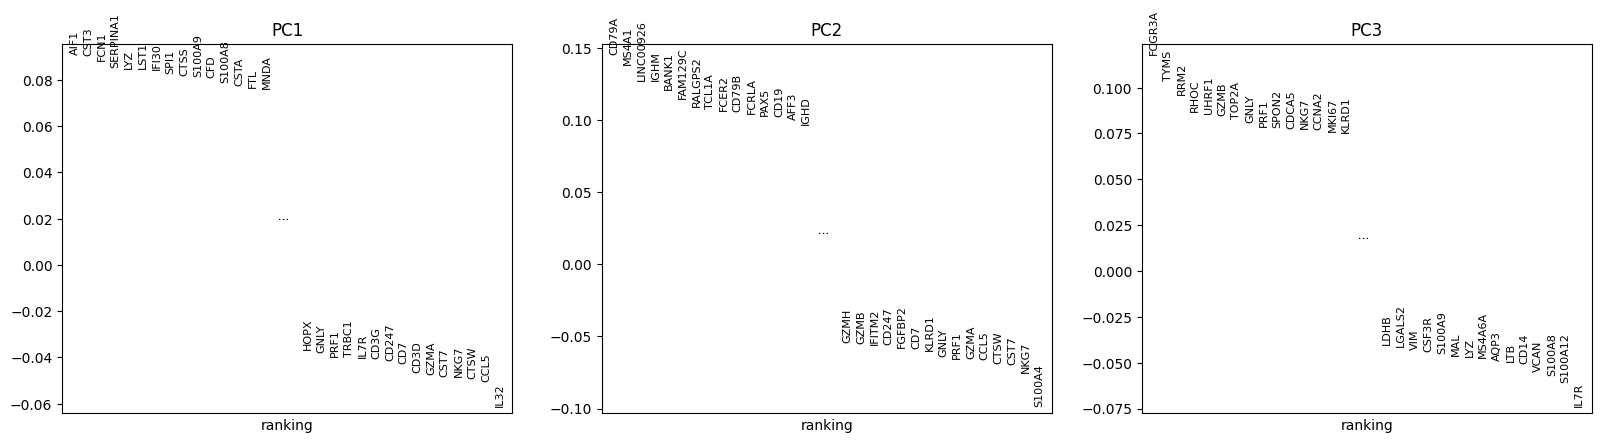

In [70]:
sc.pl.pca_loadings(adata)

## STEP 5: Nearest-neighbor graph, Clustering and UMAP projection

In [71]:
##############################################################
# construct a k nearest neighbors graph (knn)
# 1. choose which representation to use (default is 'X_pca')
# 2. choose n_neighbors (default is 15). Also can specify random_state for reproducibility.

sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15, random_state=42)

In [72]:
adata

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'patient_id_colors', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

In [73]:
##############################################################
# community detection algorithm that is used to cluster cells
# based on the neighbors graph we computed above.
#resolution: how high or low resolution clustering you want
#key added: what column name will have your clusters

sc.tl.leiden(adata, resolution=1, key_added='leiden') # default parameters

<ipython-input-73-9319bc90aa2c>:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1, key_added='leiden') # default parameters


In [78]:
adata

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'patient_id_colors', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

In [79]:
##############################################################
# run umap on the neighbors graph we computed above
sc.tl.umap(adata, min_dist=0.5, spread=1.0) # default values for the two main parameters

In [80]:
adata

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'patient_id_colors', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

### Visualize UMAP

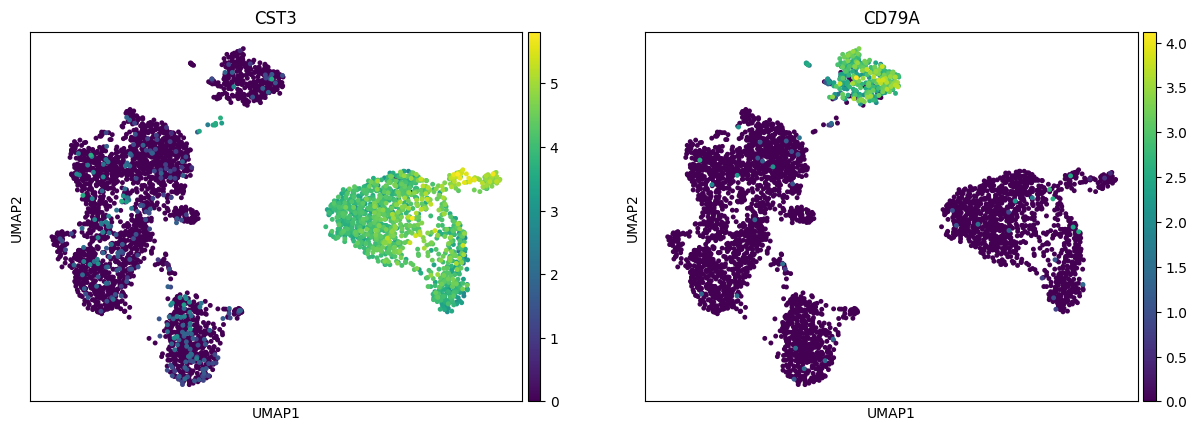

In [81]:
sc.pl.umap(adata,color=['CST3','CD79A'],size=50,layer='log1p')

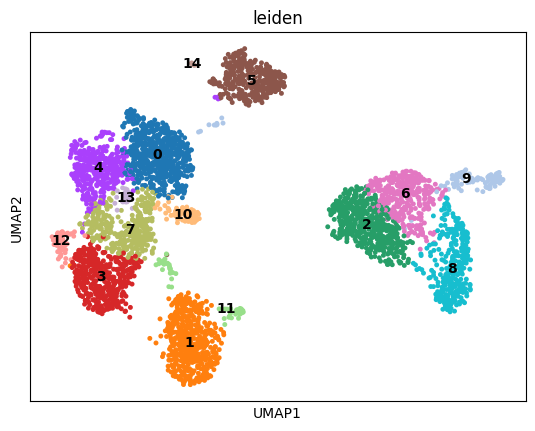

In [82]:
sc.pl.umap(adata,color='leiden',size=50,legend_loc='on data')

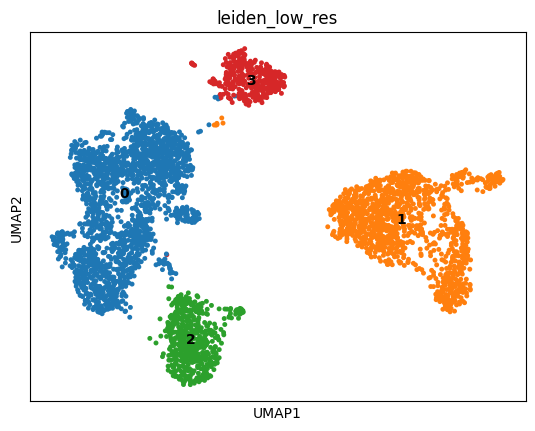

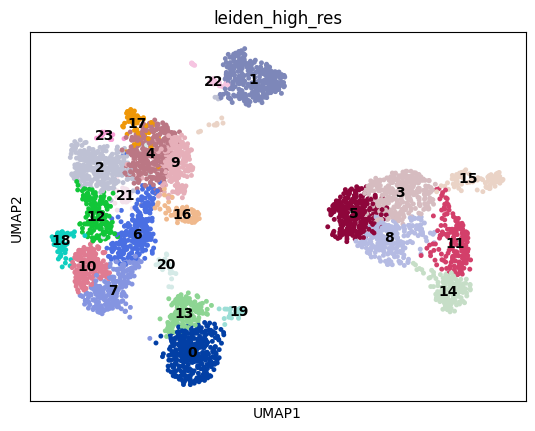

In [86]:
##############################################################
# [🔺] Cluster the cells at a lower resolution, and visualize again
# Give a different name to the labels so that we don't overwrite the 'leiden' column in obs
# Hint: run the sc.tl.leiden and sc.pl.umap functions

sc.tl.leiden(adata, resolution=0.1, key_added='leiden_low_res')
sc.pl.umap(adata,color='leiden_low_res',size=50,legend_loc='on data')
sc.tl.leiden(adata, resolution=2, key_added='leiden_high_res')
sc.pl.umap(adata,color='leiden_high_res',size=50,legend_loc='on data')

In [85]:
adata

AnnData object with n_obs × n_vars = 4103 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_low_res', 'leiden_high_res'
    var: 'gene_name', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'patient_id_colors', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'leiden_low_res', 'leiden_low_res_colors', 'leiden_high_res', 'leiden_high_res_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 

In [ ]:
# [🔹] Experiment with different neighbors, leiden and umap parameters

# lets work on a copy of the AnnData object for this
bdata = adata.copy() # anything we do with bdata won't affect adata

### pp.neighbors, tl.leiden, tl.umap and plot with pl.umap






## Extra: Differential expression analysis

In [87]:
##############################################################
sc.tl.rank_genes_groups(adata,
                        groupby='leiden_low_res',
                        method='wilcoxon',
                        layer='log1p')

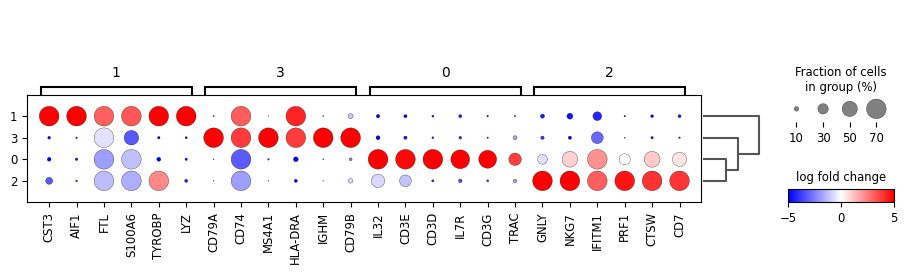

In [88]:
##############################################################
sc.pl.rank_genes_groups_dotplot(adata,
                                n_genes=6,
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=3,
                                vmax=5,
                                vmin=-5,
                                cmap='bwr',
                                dot_max=0.7)


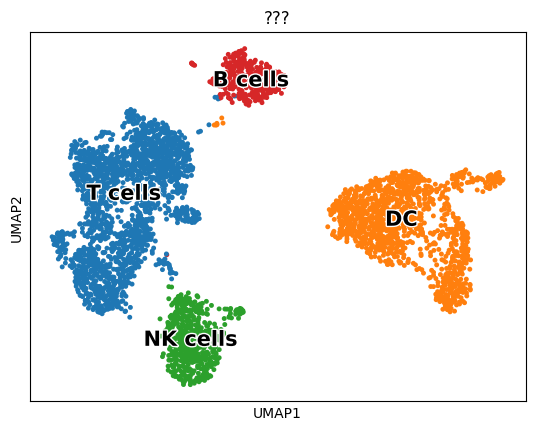

In [92]:
##############################################################
# [🔺] annotate the clusters!!

clusters_to_labels = {
    '0':'T cells',
    '1':'DC',
    '2':'NK cells',
    '3':'B cells'

}

# use the above dict to create a new column in obs with all cells labeled
# this is done by first mapping leiden_coarse column to the values of the dict
# and assigning the result to a new column in obs
adata.obs['???'] = adata.obs['leiden_low_res'].map(clusters_to_labels)


## umap plot with the new labels
sc.pl.umap(adata,color='???',size=50,legend_loc='on data',legend_fontoutline=2,legend_fontsize=15)

## STEP 6: Save the processed dataset

In [93]:
adata.write_h5ad('blood_RNA_BMS225a_single_batch.h5ad') # this will be deleted when this session ends

In [ ]:
### Too big to download so let's mount google drive from the Files tab and save it there
# adata.write_h5ad('/content/drive/MyDrive/your_project_folder/blood_RNA_BMS225a_single_batch.h5ad')

# DONE

#  --> Compact version of the code

In [ ]:
adata = sc.read_h5ad('blood_RNA_raw_counts_SCG12.h5ad') # load the AnnData object from the h5ad file
display(adata)

# QC and doublet detection
adata.var["mt"] = adata.var_names.str.startswith("MT-") # mitochondrial genes, "MT-" for human, "Mt-" for mouse
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True, percent_top = None) # calculate QC metrics
sc.pp.filter_genes(adata,min_cells=5) #filter genes
adata = adata[ adata.obs['log1p_total_counts']> 6.5 ] # filter cells based on counts
adata = adata[ adata.obs['pct_counts_mt']< 12.5 ] # filter cells based on mito percentage
sc.pp.scrublet(adata) # doublet detection with scrublet
adata = adata[ adata.obs['predicted_doublet'] == False ] # filter out detected doublets

# normalization and log-transformation
adata.layers["counts"] = adata.X.copy() # saving count data to a new layer, before we proceed with normalization
sc.pp.normalize_total(adata,target_sum=10000) # Normalizing to 10K total counts (CP10k)
sc.pp.log1p(adata) # Logarithmize the data
adata.layers['log1p'] = adata.X.copy() # save the log1p normalized counts to a new layer

# highly variable gene selection
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor='seurat_v3', layer='counts')

# dimensionality reduction (PCA)
sc.pp.scale(adata,zero_center=False) # scale each gene to unit variance (for pca only)
sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

# knn graph, umap and leiden
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15, random_state=42)
sc.tl.umap(adata, min_dist=0.5, spread=1.0)
sc.tl.leiden(adata, resolution=0.1,key_added='leiden')

# plot
sc.pl.umap(adata, color=["leiden"],legend_loc='on data',legend_fontoutline=2)

display(adata)

# Reference based celltype annotation

> A pre-processed **AnnData object** is needed to proceed with this section

In [ ]:
!pip install --quiet celltypist # https://www.celltypist.org/

<img src="https://github.com/Teichlab/celltypist/raw/main/docs/source/_static/img/logo_celltypist.png" alt="CellTypist Logo" width="300"/>

Github: https://github.com/Teichlab/celltypist

In [ ]:
import celltypist
celltypist.logger.set_level(2)

In [ ]:
# Download Immune model:
celltypist.models.download_models(model='Immune_All_Low.pkl')

### predict cell type labels

- before we start we will load the author's labels (to compare with our annotation later)

In [ ]:
# adding the author labels (no need to follow this)
adata.obs = adata.obs.join(sc.read_h5ad('blood_RNA.h5ad').obs['MK final coarse_V2'].rename('cell_type'))

In [ ]:
####################################################################
# celltypist needs an "overclustering" of the data as input to start labeling cells.
# Then it starts merging clusters with the same labels
sc.tl.leiden(adata, resolution=5, key_added='leiden_overclustering')

In [ ]:
####################################################################
# celltypist also expects adata.X to be log1p of CP10K normalized counts
adata.X = adata.layers['log1p']

In [ ]:
predictions = celltypist.annotate(adata,
                                  model = 'Immune_All_Low.pkl',
                                  majority_voting = True, # majority voting to assign labels to clusters
                                  over_clustering='leiden_overclustering')

In [ ]:
####################################################################
# update our adata with the celltypist labels
adata = predictions.to_adata()

In [ ]:
adata

#### visualize predicted labels

In [ ]:
sc.pl.umap(adata, color=["majority_voting"])

In [ ]:
sc.pl.umap(adata, color=["cell_type"],legend_fontoutline=3,palette='tab20')

In [ ]:
sc.settings.set_figure_params(dpi=100,fontsize=12, facecolor="white",figsize=(8,6),color_map='viridis')

celltypist.dotplot(predictions,use_as_reference='cell_type',use_as_prediction = 'majority_voting')

Celltypist did a pretty good job overall! But missed the gamma delta Tcell cluster (07_gd T cells)

In [ ]:
sc.settings.set_figure_params(dpi=60,fontsize=18, facecolor="white",figsize=(6,6),color_map='viridis')

# Plot gene expression
sc.pl.umap(
    adata,
    color=["TRDV2","TRGV9",'cell_type'], # Tgd markers
    size=80,
    layer = 'log1p' #### always specify this to be 100% sure which "counts" you are using
)

# Batch effect correction

 - Same steps as above but with the **full dataset**. Steps that are different are annotated with ✅

In [ ]:
### Load the full dataset (all sequencing libraries)
adata = sc.read_h5ad('blood_RNA_raw_counts.h5ad') # load the AnnData object from the h5ad file
display(adata)

#### Quality control (same)

> Advanced QC: In some cases we may need to apply different thresholds for each experimental batch or sample

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("MT-") # mitochondrial genes, "MT-" for human, "Mt-" for mouse
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True, percent_top = None) # calculate QC metrics
sc.pp.filter_genes(adata,min_cells=5) #filter genes
adata = adata[ adata.obs['log1p_total_counts']> 6.5 ] # filter cells based on counts
adata = adata[ adata.obs['pct_counts_mt']< 12.5 ] # filter cells based on mito percentage

#### Doublet detection

In [ ]:
### ✅ we specify batch key here (impossible to have doublets across experimental batches)
sc.pp.scrublet(adata, batch_key="LIBRARY_ID") # doublet detection with scrublet
adata = adata[ adata.obs['predicted_doublet'] == False ] # filter out detected doublets

#### Normalization (same)

In [ ]:
### Normalization and log-transformation (same)
adata.layers["counts"] = adata.X.copy() # saving count data to a new layer, before we proceed with normalization
sc.pp.normalize_total(adata,target_sum=10000) # Normalizing to 10K total counts (CP10k)
sc.pp.log1p(adata) # Logarithmize the data
adata.layers['log1p'] = adata.X.copy() # save the log1p normalized counts to a new layer

#### HVG selection

In [ ]:
### ✅ we specify batch key here too in order to take into account the (unwanted) variability across batches
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor='seurat_v3', layer='counts',batch_key='LIBRARY_ID')

#### PCA (same)

In [ ]:
### dimensionality reduction (PCA) (same)
sc.pp.scale(adata,zero_center=False) # scale each gene to unit variance (for pca only)
sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

#### Batch effect correction with Harmony

In [ ]:
# ✅ This method uses the result of pca, to align the pcs across batches.
sc.external.pp.harmony_integrate(adata,key='LIBRARY_ID')

In [ ]:
adata # notice that 'X_pca_harmony' was added in obsm

#### Clustering

In [ ]:
### ✅ knn graph, umap and leiden
### We just use the corrected 'X_pca_harmony' instead of 'X_pca' for the neighbors graph!
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=15, random_state=42)

In [ ]:
### Everything else is the same
sc.tl.umap(adata, min_dist=0.5, spread=1.0)
sc.tl.leiden(adata, resolution=1,key_added='leiden')

### plot
sc.pl.umap(adata, color=["leiden"],legend_loc='on data',legend_fontoutline=2)